In [1]:
import os, pathlib

file_path = os.path.dirname(os.path.realpath("__file__"))
home_dir = pathlib.Path(file_path).parent.parent.parent
os.chdir(home_dir)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils.vis_utils import plot_model
from src.common import get_optimizer
from src.fashion_mnist.data import get_fashion_mnist_train_test, get_fashion_mnist_labels_categorical
from src.fashion_mnist.file_names import SAVED_CLASSIFIER_PATH
from src.cladec import ClaDec, RefAE

tf.random.set_seed(1234)

train_images, test_images = get_fashion_mnist_train_test()
train_images = np.expand_dims(train_images, -1).astype("float32")
train_labels_c, test_labels_c = get_fashion_mnist_labels_categorical()
# get the trained model and check accuracy on test data for later reference
classifier = keras.models.load_model(SAVED_CLASSIFIER_PATH)

2022-07-06 12:26:14.609709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 12:26:14.650793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 12:26:14.651147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 12:26:14.652071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
classifier.evaluate(test_images, test_labels_c)
classifier.summary()

2022-07-06 12:26:16.945646: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


313/313 [==============================] - 3s 4ms/step - loss: 0.2431 - categorical_accuracy: 0.9185
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)     

In [4]:
layer_name = 'dense'
alpha = 0.1
optimizer = get_optimizer(learning_rate=0.01)
claDec = ClaDec(classifier, layer_name, alpha)
claDec.compile(optimizer=optimizer)

In [5]:
claDec.fit(train_images, train_labels_c, epochs=2)
# TODO save the model

Epoch 1/2


2022-07-06 12:26:18.927017: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-07-06 12:26:19.197703: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 30s 15ms/step - loss: 0.1114 - reconstruction_loss: 0.0482 - classification_loss: 0.4335
Epoch 2/2
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0438 - reconstruction_loss: 0.0363 - classification_loss: 0.1107


In [10]:
n = 10
cladec_train_dense = claDec(train_images[10:n + 10])

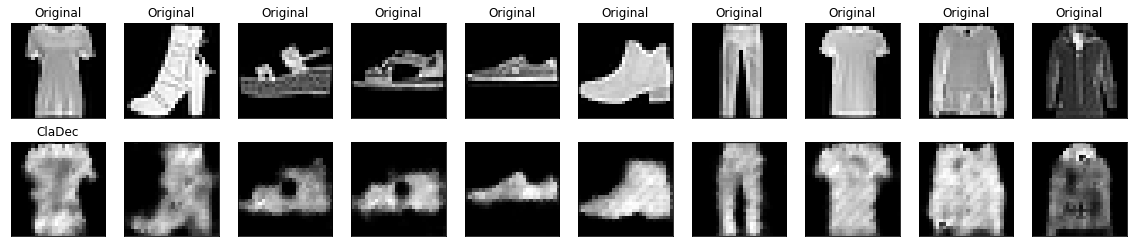

In [11]:
import matplotlib.pyplot as plt

num_rows = 2

plt.figure(figsize=(20, 2 * num_rows))
for i in range(0, n):
    # Display original
    x = i + 1
    ax = plt.subplot(num_rows, n, x)

    ax.set_title("Original")

    plt.imshow(train_images[i + 10])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display claDec
    ax = plt.subplot(num_rows, n, x + n)
    if x == 1:
        ax.set_title("ClaDec")
    plt.imshow(cladec_train_dense[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [12]:
refAE = RefAE(claDec)
refAE.compile(optimizer=optimizer)
refAE.fit(train_images, train_labels_c, epochs=2)

2022-07-06 12:28:30.827981: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/2
1875/1875 [==============================] - 28s 15ms/step - reconstruction_loss: 0.0187
Epoch 2/2
1875/1875 [==============================] - 27s 15ms/step - reconstruction_loss: 0.0080


In [13]:
refae_train_dense = refAE(train_images[10:n + 10])

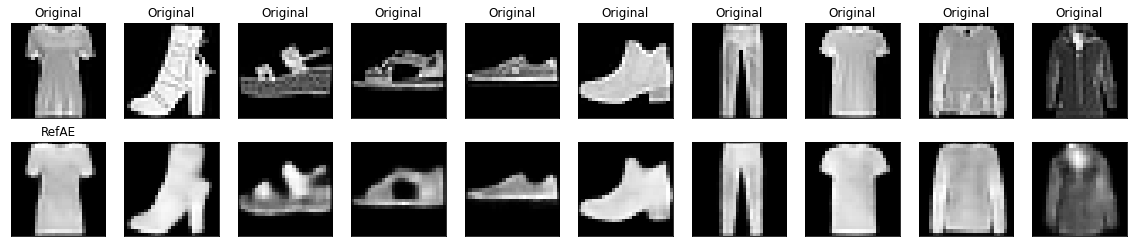

In [14]:
# TODO create Helper Function
plt.figure(figsize=(20, 2 * num_rows))
for i in range(0, n):
    # Display original
    x = i + 1
    ax = plt.subplot(num_rows, n, x)

    ax.set_title("Original")

    plt.imshow(train_images[i + 10])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display refae
    ax = plt.subplot(num_rows, n, x + n)
    if x == 1:
        ax.set_title("RefAE")
    plt.imshow(refae_train_dense[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [15]:
classifier.evaluate(test_images, test_labels_c)

313/313 [==============================] - 1s 4ms/step - loss: 0.2431 - categorical_accuracy: 0.9185


[0.24305014312267303, 0.9185000061988831]